In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
swoyam2609_fresh_and_stale_classification_path = kagglehub.dataset_download('swoyam2609/fresh-and-stale-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'fresh-and-stale-classification' dataset.
Data source import complete.


# 1️⃣ کتابخانه‌ها

In [11]:
!pip install torchmetrics

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

sns.set()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Device: cuda


# 2️⃣ تنظیم مسیر داده‌ها

In [13]:
TRAIN_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Train'
TEST_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6:])
            filenames.append(os.path.join(PATH, file, img))
    df = pd.DataFrame({'filename': filenames, 'fruit': fruit, 'fresh': fresh})
    return df

df_train = load_data(TRAIN_PATH).sample(frac=1)
df_test = load_data(TEST_PATH).sample(frac=1)

# اصلاح برچسب‌ها
df_test['fruit'] = df_test['fruit'].replace({'tamto': 'tomato', 'patato': 'potato'})
df_train = df_train[df_train['fruit'] != 'bittergourd']

df = pd.concat([df_train, df_test], axis=0)

# بالانس کردن داده‌ها
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns=['filename', 'fruit', 'fresh'])
for fruit_name, count in counts.items():
    subset = df[df['fruit'] == fruit_name]
    if count > 1500:
        subset = subset.sample(n=1500)
    df_new = pd.concat([df_new, subset], axis=0)

# برچسب‌گذاری عددی
le = LabelEncoder()
df_new['fruit_label'] = le.fit_transform(df_new['fruit'])

# تقسیم داده‌ها
df_train, df_val = train_test_split(df_new, test_size=0.15, stratify=df_new['fruit_label'])
print(df_train.shape, df_val.shape)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

(10739, 4) (1896, 4)


# 3️⃣ Dataset و Transform

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class FruitDataset(Dataset):
    def __init__(self, df, training=True):
        self.df = df.reset_index(drop=True)
        self.transform = train_transform if training else val_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filename']
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        fruit = torch.tensor(self.df.iloc[idx]['fruit_label']).long()
        fresh = torch.tensor(self.df.iloc[idx]['fresh']).long()
        return img, fruit, fresh

BATCH_SIZE = 32
train_loader = DataLoader(FruitDataset(df_train, True), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(FruitDataset(df_val, False), batch_size=BATCH_SIZE)


# 4️⃣ تعریف مدل

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7

        self.base = models.resnet18(pretrained=True)

        # فریز کمتر برای یادگیری بهتر
        for param in list(self.base.parameters())[:-5]:
            param.requires_grad = False

        self.base.fc = nn.Identity()  # حذف لایه FC اصلی

        self.shared = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.class_fruit = nn.Linear(128, 9)  # ۹ نوع میوه
        self.class_fresh = nn.Linear(128, 2)  # تازه/خراب

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=2, factor=0.5)

    def forward(self, x):
        x = self.base(x)
        x = self.shared(x)
        y_fruit = self.class_fruit(x)
        y_fresh = self.class_fresh(x)
        return y_fruit, y_fresh

# 5️⃣ آموزش مدل


In [16]:
def train_model(model, epochs=20):
    best_val_loss = np.inf
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y_fruit, y_fresh in tqdm(train_loader, leave=False):
            X, y_fruit, y_fresh = X.to(device), y_fruit.to(device), y_fresh.to(device)
            pred_fruit, pred_fresh = model(X)
            loss = model.alpha * model.loss_fn(pred_fruit, y_fruit) + (1 - model.alpha) * model.loss_fn(pred_fresh, y_fresh)
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y_fruit, y_fresh in val_loader:
                X, y_fruit, y_fresh = X.to(device), y_fruit.to(device), y_fresh.to(device)
                pred_fruit, pred_fresh = model(X)
                loss = model.alpha * model.loss_fn(pred_fruit, y_fruit) + (1 - model.alpha) * model.loss_fn(pred_fresh, y_fresh)
                val_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        model.scheduler.step(avg_val)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)

        # ذخیره بهترین مدل
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "fruit_freshness_best.pth")

    return history


model = Model().to(device)
history = train_model(model, epochs=20)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 0.5508 | Val Loss: 0.1407


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.1488 | Val Loss: 0.0878


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.1068 | Val Loss: 0.0724


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.0851 | Val Loss: 0.0570


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.0708 | Val Loss: 0.0470


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.0634 | Val Loss: 0.0470


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.0551 | Val Loss: 0.0382


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.0480 | Val Loss: 0.0335


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.0452 | Val Loss: 0.0316


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.0416 | Val Loss: 0.0280


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.0368 | Val Loss: 0.0320


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.0328 | Val Loss: 0.0277


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.0299 | Val Loss: 0.0282


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.0278 | Val Loss: 0.0246


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.0292 | Val Loss: 0.0236


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.0256 | Val Loss: 0.0250


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.0255 | Val Loss: 0.0284


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.0212 | Val Loss: 0.0193


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.0167 | Val Loss: 0.0268


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.0197 | Val Loss: 0.0270


# 6️⃣ رسم نمودار آموزش

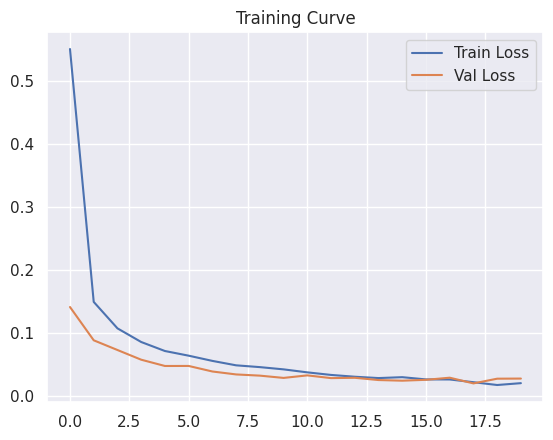

In [17]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training Curve')
plt.show()

# 7️⃣ بارگذاری بهترین مدل و پیش‌بینی تصویر جدید


In [21]:
model.load_state_dict(torch.load("fruit_freshness_best.pth"))
model.eval()

def predict_image(img_path, model, le):
    img = Image.open(img_path).convert("RGB")
    transform = val_transform
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_fruit, pred_fresh = model(img_tensor)
        fruit_idx = torch.argmax(pred_fruit, 1).item()
        fresh_idx = torch.argmax(pred_fresh, 1).item()

    fruit_name = le.inverse_transform([fruit_idx])[0]
    freshness = "Fresh" if fresh_idx == 0 else "Spoiled"

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{fruit_name} — {freshness}")
    plt.show()

    print(f"Predicted fruit: {fruit_name}")
    print(f"Freshness status: {freshness}")

    return fruit_name, freshness


# مثال

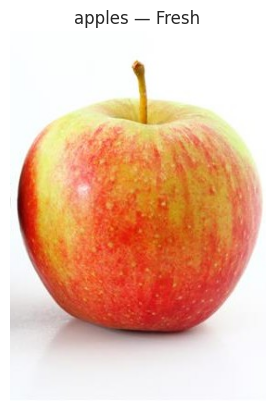

Predicted fruit: apples
Freshness status: Fresh


In [25]:
img_path = "one.jpg"
fruit, freshness = predict_image(img_path, model, le)


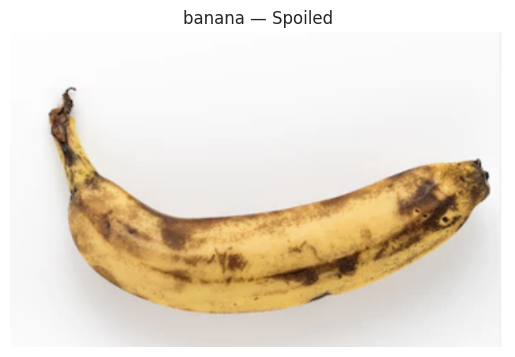

Predicted fruit: banana
Freshness status: Spoiled


In [27]:
img_path = "two.jpg"
fruit, freshness = predict_image(img_path, model, le)



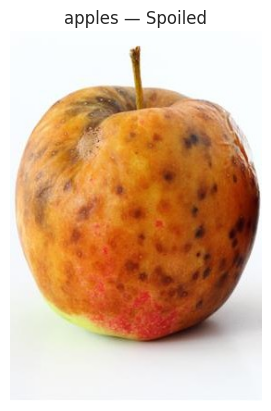

Predicted fruit: apples
Freshness status: Spoiled


In [26]:
img_path = "three.jpg"
fruit, freshness = predict_image(img_path, model, le)

